# Structural Counterfactuals (SCF)

This is an example script where we try to understand Pearl's structural counterfactuals (SCF) generation process (abduction - action - prediction) in the context of situation testing (SI) under *causal sufficiency*. 

We want to be able to take a factual tuple {$x^F$} and return it's counterfactual {$x^{SCF}$} by changing the protected attribute $A$ from $a^F=a$ to $a^{SCF}=a'$ and letting it propagate across the system of equations.

We use Figure one from [Karimi et al. (2020)](https://arxiv.org/pdf/2002.06278.pdf).

In [1]:
import random
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
# set working directory - note: all code runs from the src folder
wrk_dir = os.getcwd()
# set data path
data_path = wrk_dir + '\\' + 'data' + '\\'

### Version 1: Causal Sufficiency; without $A$
With the DAG: $X_1->Y$, $X_1->X_2$, and $X_2->Y$.

In [3]:
# overall params
np.random.seed(2022)
n = 5000

# (hyper)parameters
# p_rate = 10
# n_mu = 0.0
# n_sigma = 1.0
lambda_1 = 10000
lambda_2 = 2500
beta_1 = (3/10)
beta_2 = 5
#epsilon = 225000

u1 = lambda_1*np.random.poisson(lam=10, size=n)
u2 = lambda_2*np.random.normal(loc=0.0, scale=1.0, size=n)

# annual salary
x1 = u1
# account balance
x2 = beta_1*x1 + u2
# loan approval
y = np.sign(x1 + beta_2*x2 - 225000)

In [4]:
# make a dataset for the observables and unobservables
d = {'LoanApproval': y, 
     'AnnualSalary': x1, 
     'AccountBalance': x2,
     'u1': u1,
     'u2': u2}
data = pd.DataFrame(d)
data.head(10)

,LoanApproval,AnnualSalary,AccountBalance,u1,u2
0,-1.0,50000,14026.847358,50000,-973.152642
1,1.0,120000,36940.097383,120000,940.097383
2,-1.0,90000,23564.129008,90000,-3435.870992
3,-1.0,80000,27596.570524,80000,3596.570524
4,1.0,210000,62294.221620,210000,-705.778380
5,1.0,120000,32827.008724,120000,-3172.991276
6,-1.0,80000,19749.048087,80000,-4250.951913
7,1.0,140000,45716.973279,140000,3716.973279
8,-1.0,70000,22540.642141,70000,1540.642141
9,1.0,110000,30629.344885,110000,-2370.655115


In [5]:
# check for negative values
print(data.shape)
data = data[(data['AnnualSalary'] >= 0) & (data['AccountBalance'] >= 0)]
print(data.shape)

(5000, 5)
(5000, 5)


In [6]:
# store in data folder
data.to_csv(data_path + '\\' + 'Karimi2020_v1.csv', sep='|', index=False)

Can I say anything about the error terms' moments based on the 'observed' Us?

It seems that for the white noise, yes. Realistically, however, we assume to know $F$ and its moments - too restrictive for an additve noise model used for discrimination, no?

In [7]:
# recall u1 is a Poisson
print(round(np.mean(data['u1']), 1))
print(round(np.sqrt(np.var(data['u1'])), 1))

100244.0
32196.6


In [8]:
# recall u2 is a White Noise
print(round(np.mean(data['u2']), 1))
print(round(np.sqrt(np.var(data['u2'])), 1))

17.1
2516.0


### (1) Estimate $f_j$

My interpretation of the paper is that, under causal sufficiency, focus is on estimating $f_j$ from the $X_j = f_j(X_{pa(j)}) + U$. If we 'assume' $f_j$ to be linar, the OLS estimator (being BLUE) is the best option, right? In other words,

$ X_j = \beta_0 + \sum \beta \times X_{par(j)} + U_j$

In [9]:
model = LinearRegression(fit_intercept=True, normalize=False)

In [10]:
x = np.array(data['AnnualSalary'].copy()).reshape((-1, 1))
print(x.shape)
y = np.array(data['AccountBalance'].copy())
print(y.shape)

(5000, 1)
(5000,)


In [11]:
model.fit(x, y)

LinearRegression()

In [12]:
hat_beta1 = model.coef_[0]
hat_beta1

0.2991165342281786

In [13]:
hat_beta0 = model.intercept_
hat_beta0

105.62201565680152

In [14]:
scf_data = data[['AnnualSalary', 'AccountBalance', 'u1', 'u2']].copy()
scf_data.head(5)

,AnnualSalary,AccountBalance,u1,u2
0,50000,14026.847358,50000,-973.152642
1,120000,36940.097383,120000,940.097383
2,90000,23564.129008,90000,-3435.870992
3,80000,27596.570524,80000,3596.570524
4,210000,62294.221620,210000,-705.778380


In [15]:
scf_data['hat_AccountBalance'] = model.predict(x)
scf_data.head(5)

,AnnualSalary,AccountBalance,u1,u2,hat_AccountBalance
0,50000,14026.847358,50000,-973.152642,15061.448727
1,120000,36940.097383,120000,940.097383,35999.606123
2,90000,23564.129008,90000,-3435.870992,27026.110096
3,80000,27596.570524,80000,3596.570524,24034.944754
4,210000,62294.221620,210000,-705.778380,62920.094204


In [16]:
scf_data['diff_AccountBalance'] = round(scf_data['AccountBalance'] - scf_data['hat_AccountBalance'], 2)
scf_data.head(5)

,AnnualSalary,AccountBalance,u1,u2,hat_AccountBalance,diff_AccountBalance
0,50000,14026.847358,50000,-973.152642,15061.448727,-1034.60
1,120000,36940.097383,120000,940.097383,35999.606123,940.49
2,90000,23564.129008,90000,-3435.870992,27026.110096,-3461.98
3,80000,27596.570524,80000,3596.570524,24034.944754,3561.63
4,210000,62294.221620,210000,-705.778380,62920.094204,-625.87


(array([  11.,   76.,  261.,  617., 1048., 1266.,  978.,  503.,  189.,
          51.]),
 array([-8613.13 , -7009.916, -5406.702, -3803.488, -2200.274,  -597.06 ,
         1006.154,  2609.368,  4212.582,  5815.796,  7419.01 ]),
 <BarContainer object of 10 artists>)

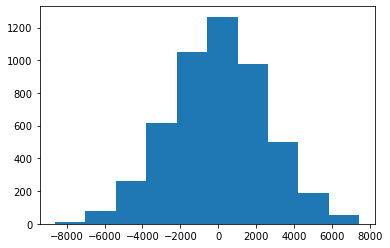

In [17]:
plt.hist(scf_data['diff_AccountBalance'])

In [18]:
scf_data['perc_diff_AccountBalance'] = round( np.sqrt( (scf_data['AccountBalance'] - scf_data['hat_AccountBalance'])**2 ) * 100 / scf_data['AccountBalance'], 2)
scf_data.head(10)

,AnnualSalary,AccountBalance,u1,u2,hat_AccountBalance,diff_AccountBalance,perc_diff_AccountBalance
0,50000,14026.847358,50000,-973.152642,15061.448727,-1034.60,7.38
1,120000,36940.097383,120000,940.097383,35999.606123,940.49,2.55
2,90000,23564.129008,90000,-3435.870992,27026.110096,-3461.98,14.69
3,80000,27596.570524,80000,3596.570524,24034.944754,3561.63,12.91
4,210000,62294.221620,210000,-705.778380,62920.094204,-625.87,1.00
5,120000,32827.008724,120000,-3172.991276,35999.606123,-3172.60,9.66
6,80000,19749.048087,80000,-4250.951913,24034.944754,-4285.90,21.70
7,140000,45716.973279,140000,3716.973279,41981.936808,3735.04,8.17
8,70000,22540.642141,70000,1540.642141,21043.779412,1496.86,6.64
9,110000,30629.344885,110000,-2370.655115,33008.440781,-2379.10,7.77


In [19]:
# can we start talking about a threshold here?
error_threshold = 5.0

scf_data[scf_data['perc_diff_AccountBalance'] <= error_threshold].shape

(2247, 7)

(array([  11.,   76.,  261.,  617., 1048., 1266.,  978.,  503.,  189.,
          51.]),
 array([-8613.13 , -7009.916, -5406.702, -3803.488, -2200.274,  -597.06 ,
         1006.154,  2609.368,  4212.582,  5815.796,  7419.01 ]),
 <BarContainer object of 10 artists>)

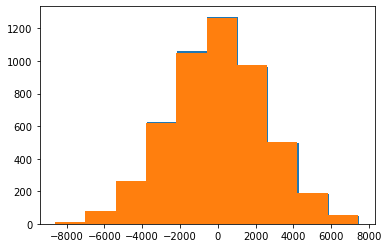

In [20]:
plt.hist(scf_data['u2'])
plt.hist(scf_data['diff_AccountBalance'])

From the histograms of above, it seems that under cuasal sufficiency the abduction step essentially represents the individual error terms!

### (2) Abduction

In [21]:
scf_data['hat_u1'] = scf_data['AnnualSalary']
scf_data['hat_u2'] = round(scf_data['AccountBalance'] - model.predict(x), 2)
scf_data.head(5)

,AnnualSalary,AccountBalance,u1,u2,hat_AccountBalance,diff_AccountBalance,perc_diff_AccountBalance,hat_u1,hat_u2
0,50000,14026.847358,50000,-973.152642,15061.448727,-1034.60,7.38,50000,-1034.60
1,120000,36940.097383,120000,940.097383,35999.606123,940.49,2.55,120000,940.49
2,90000,23564.129008,90000,-3435.870992,27026.110096,-3461.98,14.69,90000,-3461.98
3,80000,27596.570524,80000,3596.570524,24034.944754,3561.63,12.91,80000,3561.63
4,210000,62294.221620,210000,-705.778380,62920.094204,-625.87,1.00,210000,-625.87


In [22]:
scf_data = scf_data[['AnnualSalary', 'AccountBalance', 'hat_u1', 'hat_u2']]
scf_data.head(5)

,AnnualSalary,AccountBalance,hat_u1,hat_u2
0,50000,14026.847358,50000,-1034.60
1,120000,36940.097383,120000,940.49
2,90000,23564.129008,90000,-3461.98
3,80000,27596.570524,80000,3561.63
4,210000,62294.221620,210000,-625.87


### (3) ... and Intervention and Prediction

In [23]:
round(np.mean(scf_data['AccountBalance']))

30090

In [24]:
do = 30000
do_30000 = np.repeat(do, repeats=scf_data.shape[0]).reshape((-1, 1))
#do_30000

In [25]:
scf_data['scf_AccountBalance'] = round(model.predict(do_30000) + scf_data['hat_u2'], 2)
scf_data.head(5)

,AnnualSalary,AccountBalance,hat_u1,hat_u2,scf_AccountBalance
0,50000,14026.847358,50000,-1034.60,8044.52
1,120000,36940.097383,120000,940.49,10019.61
2,90000,23564.129008,90000,-3461.98,5617.14
3,80000,27596.570524,80000,3561.63,12640.75
4,210000,62294.221620,210000,-625.87,8453.25


(array([  11.,   76.,  261.,  617., 1048., 1266.,  978.,  503.,  189.,
          51.]),
 array([  465.99 ,  2069.204,  3672.418,  5275.632,  6878.846,  8482.06 ,
        10085.274, 11688.488, 13291.702, 14894.916, 16498.13 ]),
 <BarContainer object of 10 artists>)

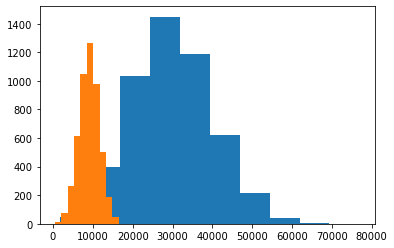

In [26]:
plt.hist(scf_data['AccountBalance'])
plt.hist(scf_data['scf_AccountBalance'])

(array([4934.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          66.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

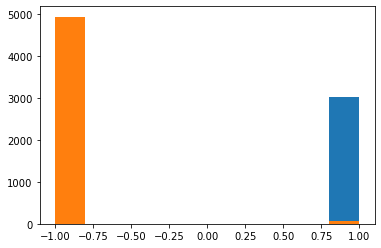

In [27]:
plt.hist(data['LoanApproval'])
plt.hist(np.sign(scf_data['AnnualSalary'] + beta_2*scf_data['scf_AccountBalance'] - 225000))

*Remarks:*

Above all, it seems that under causal sufficiency and under structural equations with linear functional form and an additive noise (ideally, Gaussian), we can perform Pearl's structural counterfactuals wihtout having to go crazy on the latent space... of course, here some very stringent assumptions take place: we assume a noise additve model, we assume a linear form, and we assume $X_2$ to have Gaussian errors. This is possible because we know the data generating process. We would then need to wonder what does this imply when some of these assumptions don't hold?

On $\alpha$, it roughly represents the level of variation of the noise. This is clearer under *white noise*. Similarly, now it is more clear to me what $U$ represents: the (most likely) individual error or unit characterization given the evidence for for each individual.

Here, we don't need a latent space nor anything fancy for generating the counterfactuals. This indeed is a simple model but it illustrates a new approach for discrimination discovery: fairness given the difference. I think we should focus on finishing this for situation testing under a simple approach and then push this further by exploring the consequences of non-normal noise or even non-linear forms.

*Remarks on Kusner (2017)*

I'd argue further that counterfactual fairness as a definition is not that useful, and, furthermore, the FairLearner they defined as nothing more than a 2-stage regression to construct a latent space that is perpendicular to the protected attributes. This is not useful nor for prediction nor for auditing. 

How they cobstruct $U$ is nothing more than to find the missing confounder. That's not really an abduction step! Because you still have individual variability for each variable... you just want to be able to split the residual variance into what is known and what is not!!!

In fact, my hunch is that the law school data has a low risk of confounding! That's why performance doesn't drop!

### Version 2: Causal Sufficiency; with $A$
With the DAG: $X_1->Y$, $X_1->X_2$, $X_2->Y$, $A -> X_1$, and $A -> X_2$.

In [87]:
# create systematic penalties around A
np.random.seed(2020) # to avoid identical draws as the Us
n = 5000

# Let A be Gender
p_men = 0.65
uA = random.choices(population=[0, 1], weights=[p_men, (1 - p_men)], k=n)
A = np.asanyarray(uA) # where A=1 represents female

bias_a1 = (-6500)*np.random.poisson(lam=10, size=n)
bias_a2 = (-500)*np.random.chisquare(df=4, size=n)

In [93]:
#plt.hist(A)
#plt.hist(bias_a1)
#plt.hist(bias_a2)

In [89]:
# overall params
np.random.seed(2022)
n = 5000

# previous hyperparams
lambda_1 = 10000
lambda_2 = 2500
beta_1 = (3/10)
beta_2 = 5
#epsilon = 225000

u1 = lambda_1*np.random.poisson(lam=10, size=n)
u2 = lambda_2*np.random.normal(loc=0.0, scale=1.0, size=n)

# annual salary
n_x1 = u1 + A*bias_a1
# account balance
n_x2 = beta_1*n_x1 + u2 + A*bias_a2
# loan approval
n_y = np.sign(n_x1 + beta_2*n_x2 - 225000)

In [90]:
# store data for testing RStan 
n_d = {'LoanApproval': n_y, 
     'AnnualSalary': n_x1, 
     'AccountBalance': n_x2,
     'u1': u1,
     'u2': u2,
     'Gender': A}
n_data = pd.DataFrame(n_d)
n_data.head(10)

,LoanApproval,AnnualSalary,AccountBalance,u1,u2,Gender
0,-1.0,-15000,-8105.101422,50000,-973.152642,1
1,1.0,120000,36940.097383,120000,940.097383,0
2,-1.0,90000,23564.129008,90000,-3435.870992,0
3,-1.0,80000,27596.570524,80000,3596.570524,0
4,1.0,210000,62294.221620,210000,-705.778380,0
5,1.0,120000,32827.008724,120000,-3172.991276,0
6,-1.0,80000,19749.048087,80000,-4250.951913,0
7,1.0,94500,29760.091484,140000,3716.973279,1
8,-1.0,70000,22540.642141,70000,1540.642141,0
9,1.0,110000,30629.344885,110000,-2370.655115,0


(array([1600.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         109.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

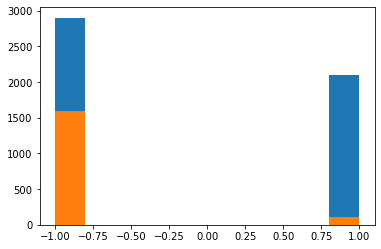

In [91]:
plt.hist(n_data['LoanApproval'])
plt.hist(n_data[n_data['Gender']==1]['LoanApproval']) # this is the factual!

In [92]:
# store in data folder
n_data.to_csv(data_path + '\\' + 'Karimi2020_v2.csv', sep='|', index=False)

For SCFs, we need to estimate the weighst (i.e., causal inference) for Account Balance and Annual Salary before we estimate $u_1$ and $u_2$; interven $A$; and precidt the counterfactual values for $x_1$ and $x_2$.

In [100]:
model_sal = LinearRegression(fit_intercept=True, normalize=False)
model_acc = LinearRegression(fit_intercept=True, normalize=False)

In [107]:
x_sal = np.array(n_data['Gender'].copy()).reshape((-1, 1))
print(x_sal.shape)
y_sal = np.array(n_data['AnnualSalary'].copy())
print(y_sal.shape)

x_acc = np.array(n_data[['AnnualSalary', 'Gender']].copy())#.reshape((-1, 1))
print(x_acc.shape)
y_acc = np.array(n_data['AccountBalance'].copy())
print(y_acc.shape)

(5000, 1)
(5000,)
(5000, 2)
(5000,)


In [104]:
model_sal.fit(x_sal, y_sal)
model_acc.fit(x_acc, y_acc)

LinearRegression()

In [105]:
model_sal.coef_

array([-66053.03806559])

In [110]:
model_sal.intercept_

100671.52841081738

In [106]:
model_acc.coef_

array([ 2.99318184e-01, -1.97862016e+03])

In [111]:
model_acc.intercept_

83.50955875149884

In [139]:
n_scf_data = n_data[['LoanApproval', 'AnnualSalary', 'AccountBalance', 'Gender', 'u1', 'u2']].copy()
n_scf_data.head(5)

,LoanApproval,AnnualSalary,AccountBalance,Gender,u1,u2
0,-1.0,-15000,-8105.101422,1,50000,-973.152642
1,1.0,120000,36940.097383,0,120000,940.097383
2,-1.0,90000,23564.129008,0,90000,-3435.870992
3,-1.0,80000,27596.570524,0,80000,3596.570524
4,1.0,210000,62294.221620,0,210000,-705.778380


In [140]:
n_scf_data['hat_u1'] = round(n_scf_data['AnnualSalary'] - model_sal.predict(x_sal), 2)
n_scf_data['hat_u2'] = round(n_scf_data['AccountBalance'] - model_acc.predict(x_acc), 2)
n_scf_data.head(5)

,LoanApproval,AnnualSalary,AccountBalance,Gender,u1,u2,hat_u1,hat_u2
0,-1.0,-15000,-8105.101422,1,50000,-973.152642,-49618.49,-1720.22
1,1.0,120000,36940.097383,0,120000,940.097383,19328.47,938.41
2,-1.0,90000,23564.129008,0,90000,-3435.870992,-10671.53,-3458.02
3,-1.0,80000,27596.570524,0,80000,3596.570524,-20671.53,3567.61
4,1.0,210000,62294.221620,0,210000,-705.778380,109328.47,-646.11


(array([2.000e+00, 3.100e+01, 3.680e+02, 1.233e+03, 1.686e+03, 1.165e+03,
        4.150e+02, 8.600e+01, 1.300e+01, 1.000e+00]),
 array([-144118.49 , -112773.794,  -81429.098,  -50084.402,  -18739.706,
          12604.99 ,   43949.686,   75294.382,  106639.078,  137983.774,
         169328.47 ]),
 <BarContainer object of 10 artists>)

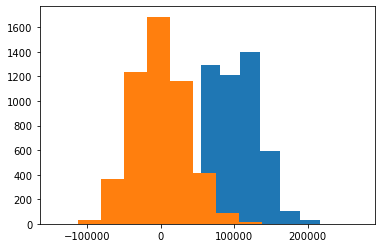

In [141]:
plt.hist(n_scf_data['u1'])
plt.hist(n_scf_data['hat_u1'])

(array([  18.,   79.,  285.,  690., 1186., 1285.,  914.,  415.,  112.,
          16.]),
 array([-9188.73 , -7411.538, -5634.346, -3857.154, -2079.962,  -302.77 ,
         1474.422,  3251.614,  5028.806,  6805.998,  8583.19 ]),
 <BarContainer object of 10 artists>)

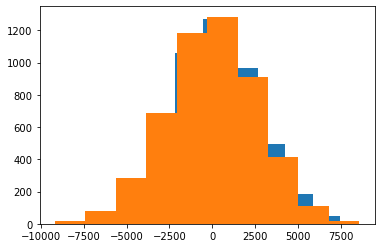

In [142]:
plt.hist(n_scf_data['u2'])
plt.hist(n_scf_data['hat_u2'])

In [143]:
# intervene on A
do_male = np.repeat(0, repeats=n_scf_data.shape[0]).reshape((-1, 1))

In [144]:
n_scf_data['scf_AnnualSalary'] = round(model_sal.predict(do_male) + n_scf_data['hat_u1'], 2)
n_scf_data.head(5)

,LoanApproval,AnnualSalary,AccountBalance,Gender,u1,u2,hat_u1,hat_u2,scf_AnnualSalary
0,-1.0,-15000,-8105.101422,1,50000,-973.152642,-49618.49,-1720.22,51053.04
1,1.0,120000,36940.097383,0,120000,940.097383,19328.47,938.41,120000.00
2,-1.0,90000,23564.129008,0,90000,-3435.870992,-10671.53,-3458.02,90000.00
3,-1.0,80000,27596.570524,0,80000,3596.570524,-20671.53,3567.61,80000.00
4,1.0,210000,62294.221620,0,210000,-705.778380,109328.47,-646.11,210000.00


(array([2.000e+00, 3.100e+01, 3.680e+02, 1.233e+03, 1.686e+03, 1.165e+03,
        4.150e+02, 8.600e+01, 1.300e+01, 1.000e+00]),
 array([-43446.96 , -12102.264,  19242.432,  50587.128,  81931.824,
        113276.52 , 144621.216, 175965.912, 207310.608, 238655.304,
        270000.   ]),
 <BarContainer object of 10 artists>)

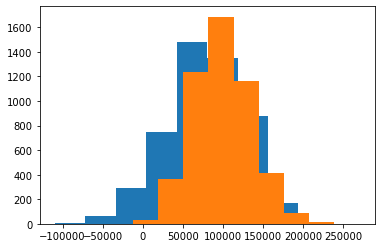

In [145]:
plt.hist(n_scf_data['AnnualSalary'])
plt.hist(n_scf_data['scf_AnnualSalary'])

In [146]:
temp_do = n_scf_data[['scf_AnnualSalary']].copy()
temp_do['Gender'] = do_male
temp_do.head(5)

,scf_AnnualSalary,Gender
0,51053.04,0
1,120000.00,0
2,90000.00,0
3,80000.00,0
4,210000.00,0


In [147]:
n_scf_data['scf_AccountBalance'] = round(model_acc.predict(temp_do) + n_scf_data['hat_u2'], 2)
n_scf_data.head(5)

,LoanApproval,AnnualSalary,AccountBalance,Gender,u1,u2,hat_u1,hat_u2,scf_AnnualSalary,scf_AccountBalance
0,-1.0,-15000,-8105.101422,1,50000,-973.152642,-49618.49,-1720.22,51053.04,13644.39
1,1.0,120000,36940.097383,0,120000,940.097383,19328.47,938.41,120000.00,36940.10
2,-1.0,90000,23564.129008,0,90000,-3435.870992,-10671.53,-3458.02,90000.00,23564.13
3,-1.0,80000,27596.570524,0,80000,3596.570524,-20671.53,3567.61,80000.00,27596.57
4,1.0,210000,62294.221620,0,210000,-705.778380,109328.47,-646.11,210000.00,62294.22


(array([  11.,   65.,  396., 1181., 1561., 1137.,  504.,  121.,   21.,
           3.]),
 array([-9234.79 ,  -622.275,  7990.24 , 16602.755, 25215.27 , 33827.785,
        42440.3  , 51052.815, 59665.33 , 68277.845, 76890.36 ]),
 <BarContainer object of 10 artists>)

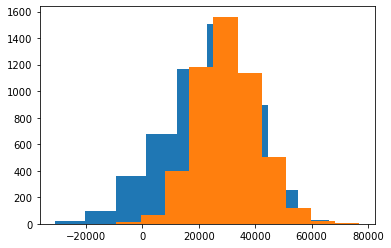

In [148]:
plt.hist(n_scf_data['AccountBalance'])
plt.hist(n_scf_data['scf_AccountBalance'])

In [149]:
n_scf_data['scf_LoanApproval'] = np.sign(n_scf_data['scf_AnnualSalary'] + beta_2*n_scf_data['scf_AccountBalance'] - 225000)
n_scf_data.head(5)

,LoanApproval,AnnualSalary,AccountBalance,Gender,u1,u2,hat_u1,hat_u2,scf_AnnualSalary,scf_AccountBalance,scf_LoanApproval
0,-1.0,-15000,-8105.101422,1,50000,-973.152642,-49618.49,-1720.22,51053.04,13644.39,-1.0
1,1.0,120000,36940.097383,0,120000,940.097383,19328.47,938.41,120000.00,36940.10,1.0
2,-1.0,90000,23564.129008,0,90000,-3435.870992,-10671.53,-3458.02,90000.00,23564.13,-1.0
3,-1.0,80000,27596.570524,0,80000,3596.570524,-20671.53,3567.61,80000.00,27596.57,-1.0
4,1.0,210000,62294.221620,0,210000,-705.778380,109328.47,-646.11,210000.00,62294.22,1.0


(array([1977.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3023.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

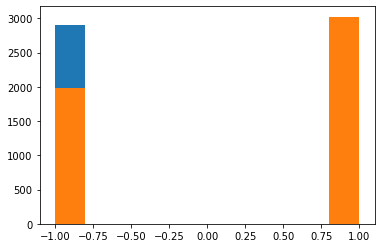

In [151]:
plt.hist(n_scf_data['LoanApproval'])
plt.hist(n_scf_data['scf_LoanApproval'])

(array([ 675.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1034.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

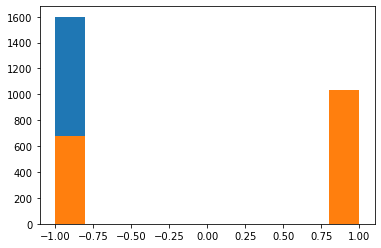

In [152]:
plt.hist(n_scf_data[n_scf_data['Gender']==1]['LoanApproval'])
plt.hist(n_scf_data[n_scf_data['Gender']==1]['scf_LoanApproval'])

### Version 2: no causal sufficiency

$U -> X_1; U -> X_2; X_1 -> X_2$

A violation of the causal sufficiency essentially introduces an endogeneity problem where we are unable to retrieve the original causal weights... which is an issue for performing the abduction step (we can't properly identify the exogenous vars) and, in turn, a problem for generating the counterfactuals.

In [ ]:
# clear values
del u1, u2, x1, x2, y

In [ ]:
# overall params
np.random.seed(2022)
n = 5000

# (hyper)parameters
lambda_1 = 10000
lambda_2 = 2500
beta_1 = (3/10)
beta_2 = 5
#epsilon = 225000

# introduce the confounder z
z = np.random.normal(loc=0.0, scale=1.75, size=n)
lambda_z1 = 1000
lambda_z2 = 3*lambda_z1

# input to the errors
u1 = lambda_1*np.random.poisson(lam=10, size=n)            + lambda_z1*z
u2 = lambda_2*np.random.normal(loc=0.0, scale=1.0, size=n) + lambda_z2*z

# annual salary
x1 = u1
# account balance
x2 = beta_1*x1 + u2

# loan approval
y = np.sign(x1 + beta_2*x2 - 225000)

In [ ]:
# store data for testing RStan 
d2 = {'LoanApproval': y, 
      'AnnualSalary': x1, 
      'AccountBalance': x2,
      'u1': u1,
      'u2': u2,
      'z': z}
data2 = pd.DataFrame(d2)
data2.head(5)

In [ ]:
# check for negative values
print(data2.shape)
data2 = data2[(data2['AnnualSalary'] >= 0) & (data2['AccountBalance'] >= 0)]
print(data2.shape)

In [ ]:
# store in data folder
data2.to_csv(data_path + '\\' + 'Karimi2020_v2.csv', sep='|', index=False)

In [ ]:
# just in case
del x, y, model

In [ ]:
#from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True, normalize=False)

In [ ]:
x = np.array(data2['AnnualSalary'].copy()).reshape((-1, 1))
print(x.shape)
x

In [ ]:
y = np.array(data2['AccountBalance'].copy())
print(y.shape)
y

In [ ]:
# fit model
model.fit(x, y)

In [ ]:
hat_beta1 = model.coef_[0]
print(hat_beta1)

hat_beta0 = model.intercept_
print(hat_beta0)

In [ ]:
# check the abduction step!!!
plt.hist(round(data2['AccountBalance'] - model.predict(x), 2)) #hat_u2
plt.hist(data2['u2']) #u2

If you look at this histogram versus the one below where Z is specified, we seem to recover $U_2$ quite well. This is very important for SCF as: a) we show the risk of confounders, b) we show that abduction step is still variable-specific and it's not just sampling from the latent space...

In [ ]:
#from sklearn.linear_model import LinearRegression
model2 = LinearRegression(fit_intercept=True, normalize=False)

In [ ]:
x2 = np.array(data2[['AnnualSalary', 'z']].copy())#.reshape((1, -1))
print(x2.shape)
x2

In [ ]:
# fit model with 'observed' confounder
model2.fit(x2, y)

In [ ]:
hat_beta1 = model2.coef_[0]
print(hat_beta1)

hat_beta2 = model2.coef_[1]
print(hat_beta2)

hat_beta0 = model2.intercept_
print(hat_beta0)

(Above:) I'm not retrieving the weight of the confounder $Z$ but I get closer to $\beta_1$.

In [ ]:
# the coefficients
model2.coef_

In [ ]:
# check the counterfactuals
scf_data = data2[['AnnualSalary', 'AccountBalance', 'u1', 'u2', 'z']].copy()
scf_data.head(5)

In [ ]:
scf_data['hat_AccountBalance'] = model2.predict(x2)
scf_data.head(5)

In [ ]:
scf_data['hat_u1'] = scf_data['AnnualSalary']
scf_data['hat_u2'] = round(scf_data['AccountBalance'] - model2.predict(x2), 2)
scf_data.head(5)

In [ ]:
# under this, we would overestimate u2
plt.hist(scf_data['u2'])
plt.hist(scf_data['hat_u2'])

In [ ]:
# # consider individual i: what is the counterfactual of y_i?
# # here, in ST, want the STRUCTURAL COUNTERFACTUAL x_scf, not too interested in y_scf
# # because want to match x_scf with those that don't share the protected attribute memebership of i
# i = 3
# data.loc[i, ]

# # Step 1: Abduction
# # Get U's given the evidence X's [assuming causal sufficiency and, ofc, a known causal graph]

# # u1 given x1: from Fig.1, x1 = u1 and thus u1 = x1
# u1_i = data.loc[i, 'X1']
# print(u1_i)

# # u2 given x2: from Fig.1, x2 = (3/10)*x1 + u2 and thus u2 = x2 - (3/10)*x1
# u2_i = data.loc[i, 'X2'] - (3/10)*data.loc[i, 'X1']
# print(u2_i)

# # Step 2: Action
# # Given the SCM, intervene it accordingly using the do-operator 
# delta = 5000

# # Org SCM M:
# # x1 = u1             [salary]
# # x2 = (3/10)*x1 + u2 [balance]

# # do(X1 := X1 + delta), then M':
# # X1' := X1 + delta
# # X2 = (3/10)*X1' + U2

# # Step 3: Prediction (notice at at i-level)
# # Apply the chagnes on M' and get the scf tuple 

# x1_i_scf = data.loc[i, 'X1'] + delta
# print(x1_i_scf)

# x2_i_scf = (3/10)*x1_i_scf + u2_i
# print(x2_i_scf)

# print(data.loc[i, 'Y'])
# # vs
# print(np.sign(x1_i_scf + 5*x2_i_scf - 225000))

### TODO...

with the DAG: X1->Y, X1->X2, X->Y, A->X1, A->X2 such that $A$ is gender (A=1 female, A=0 male).

In [ ]:
p_men = 0.65
uA = random.choices(population=[0, 1], weights=[p_men, (1 - p_men)], k=n)
plt.hist(uA)

In [ ]:
#u1 = 10000*np.random.poisson(lam=10, size=n)
#u2 = 2500*np.random.normal(loc=0.0, scale=1.0, size=n)
#uA = see previous cell!

# gender 
A = np.asanyarray(uA)
# and its weights (systematic issue) | we avoid direct effects (as it would be ilegal and inline with Hecker's view)
beta1 = -9500
beta2 = -500

# annual salary
n_x1 = lambda_1*u1 + beta1*A
# account balance
n_x2 = (3/10)*n_x1 + lambda_2*u2 + beta2*A
# loan approval
n_y = np.sign(n_x1 + 5*n_x2 - 225000)

In [ ]:
# plot the factual distribution
plt.hist(n_y)

In [ ]:
# store data for testing RStan 
d_test = {'LoanApproval': n_y, 
          'AnnualSalary': n_x1, 
          'AccountBalance': n_x2,
          'Gender': A,
          'u1': u1,
          'l_u1': lambda_1*u1,
          'u2': u2,
          'l_u2': lambda_2*u2}
data_test = pd.DataFrame(d_test)
data_test.head(10)

In [ ]:
# store in data folder
data_test.to_csv(data_path + '\\' + 'Karimi2020_v2.csv', sep='|', index=False)

In [ ]:
# make a dataset for the observables*
# *include unobservables too... here, imagine you ran the MCMC before and estimated u|evidence
d = {'Y': y, 'X1': x1, 'X2': x2, 
     'Gender': A, 'nY': n_y, 'nX1': n_x1, 'nX2': n_x2,
     'U1_hat': u1, 'U2_hat': u2, 'uA': uA}
data = pd.DataFrame(d)
data.head(10)

In [ ]:
# total of females
n_f = data[data['Gender']==1].shape[0]
# total of males
n_m = data[data['Gender']==0].shape[0]

# unbiased
print('female unbiased')
print(data[(data['Gender']==1) & (data['Y']==1)].shape[0] / n_f)
print('male unbiased')
print(data[(data['Gender']==0) & (data['Y']==1)].shape[0] / n_m)

# biased
print('female biased')
print(data[(data['Gender']==1) & (data['nY']==1)].shape[0] / n_f)
print('male biased')
print(data[(data['Gender']==0) & (data['nY']==1)].shape[0] / n_m)

# TODO: would this show in a trained model?

### Would this translate into some trained model?

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, Lasso
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.tree import DecisionTreeClassifier
# from xgboost import XGBRegressor, XGBClassifier
# from catboost import CatBoostClassifier

In [ ]:
data.columns

In [ ]:
u_data = data[['Y', 'X1', 'X2', 'Gender']].copy()
print(u_data.shape)

b_data = data[['nY', 'nX1', 'nX2', 'Gender']].copy()
print(b_data.shape)

In [ ]:
# todo: let's do a simple logit here, later we can reuse the FairEncoder code and streamline multiple models
# todo: also create an utils files accordingly
# todo: get comfortable with Pipeline

b_data['nY2'] = np.where(b_data['nY']==-1, 0 ,b_data['nY'])
print(b_data[['nY', 'nY2']].head(10))

targets = ['nY2', 'nY']
y = b_data['nY2']
X = b_data.drop(columns=targets)

In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.5, random_state=42)

In [ ]:
clf = LogisticRegression(random_state=0).fit(X_tr, y_tr.values.ravel())

In [ ]:
clf.coef_

In [ ]:
y_pr = clf.predict(X_te)

In [ ]:
conf_matrix = confusion_matrix(y_pr, y_te)
conf_matrix

In [ ]:
# todo: move later to some utils.py files 
def calculate_cm(true, preds):
    
    # Obtain the confusion matrix
    cm = confusion_matrix(preds, true)
    
    # Return all
    cm_dict = dict()

    #  https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
    FP = cm.sum(axis=0) - np.diag(cm)
    cm_dict['FP'] = FP
    FN = cm.sum(axis=1) - np.diag(cm)
    cm_dict['FN'] = FN
    TP = np.diag(cm)
    cm_dict['TP'] = TP
    TN = cm.sum() - (FP + FN + TP)
    cm_dict['TN'] = TN
    
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP / (TP + FN)
    cm_dict['TPR'] = TPR
    # Specificity or true negative rate
    TNR = TN / (TN + FP)
    cm_dict['TNR'] = TNR
    
    # todo: expand dict for others
    # Precision or positive predictive valbue
    PPV = TP / (TP + FP)
    # Negative predictive value
    NPV = TN / (TN + FN)
    # Fall out or false positive rate
    FPR = FP / (FP + TN)
    # False negative rate
    FNR = FN / (TP + FN)
    # False discovery rate
    FDR = FP / (TP + FP)

    # Overall accuracy
    ACC = (TP + TN) / (TP + FP + FN + TN)

    #return cm_dict
    return TPR[0] #esto esta bien!

In [ ]:
# reference group (males, or A=0): group 2
aux = X_te.copy()
aux['target'] = y_te

# Filter the data
g1 = X_te[X_te['Gender'] == 1]
g2 = X_te[X_te['Gender'] == 0]

# Filter the ground truth
g1_true = aux[aux['Gender'] == 1].target
g2_true = aux[aux['Gender'] == 0].target

# Do predictions
p1 = clf.predict(g1)
p2 = clf.predict(g2)

# Extract metrics for each group | here, taking the true positive rate
res1 = calculate_cm(p1, g1_true)
print(res1)
res2 = calculate_cm(p2, g2_true)
print(res2)

res1 - res2

In [ ]:
#https://www.analyticsvidhya.com/blog/2020/04/confusion-matrix-machine-learning/
# TPR = TP / (TP + FP)

print(confusion_matrix(p1, g1_true))
tpr_1 = confusion_matrix(p1, g1_true)[0][0] / (confusion_matrix(p1, g1_true)[0][0] + confusion_matrix(p1, g1_true)[0][1])
print(tpr_1)

print(confusion_matrix(p2, g2_true))
tpr_2 = confusion_matrix(p2, g2_true)[0][0] / (confusion_matrix(p2, g2_true)[0][0] + confusion_matrix(p2, g2_true)[0][1])
print(tpr_2)

In [ ]:
def metric_calculator(model, data: pd.DataFrame, truth: pd.DataFrame, col: str, group1, group2):
    #reference group is group2!!
    
    aux = data.copy()
    aux["target"] = truth

    # Filter the data
    g1 = data[data[col] == group1]
    g2 = data[data[col] == group2]

    # Filter the ground truth
    g1_true = aux[aux[col] == group1].target
    g2_true = aux[aux[col] == group2].target

    # Do predictions
    p1 = model.predict(g1)
    p2 = model.predict(g2)

    # Extract metrics for each group | here, taking the true positive rate
    res1 = calculate_cm(p1, g1_true)
    print(res1)
    res2 = calculate_cm(p2, g2_true)
    print(res2)
    
    return res1 - res2

In [ ]:
metric_calculator(model=clf, data=X_te, truth=y_te, col='Gender', group1=1, group2=0)

In [ ]:
metric_calculator(model=clf, data=X_tr, truth=y_tr, col='Gender', group1=1, group2=0)